Scope acquisition
=================

.. Note::
        A version of this tutorial suitable for RF modules can be found [here](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/rf/scope_acquisition.html).

The QRM/QRM-RF instruments have high speed analog to digital capability for performing measurements. In this tutorial we will demonstrate the sequencer based scope acquisition procedure allowing you to inspect and process the raw input
of the QRM. We will also have a look at how to average multiple scope acquisitions in hardware (see section [Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html#acquisitions)). We will show this by using a QRM and directly connecting outputs
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on
the outputs and simultaneously acquire the resulting waveforms on the inputs. As this tutorial uses waveform generation and acquisition, it will cover usage of `waveforms` and `acquisitions` in the sequence.

As with all operations with QxM instruments, the devices will be controlled by preparing and uploading sequences onto the Q1 processors.
For more info on the features, programming and operation of Q1 sequence processor please view [Q1 Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html).

Setup
-----

First, we are going to import the required packages.

In [1]:

from __future__ import annotations

import json
import math
from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from qcodes.instrument import find_or_create_instrument

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
modules

{4: <Module: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = modules[4]

Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence.

In [8]:
# Waveform parameters
waveform_length = 120  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(waveform_length, std=0.12 * waveform_length).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [math.sin((2 * math.pi / waveform_length) * i) for i in range(0, waveform_length)],
        "index": 1,
    },
}

Let's plot the waveforms to see what we have created.

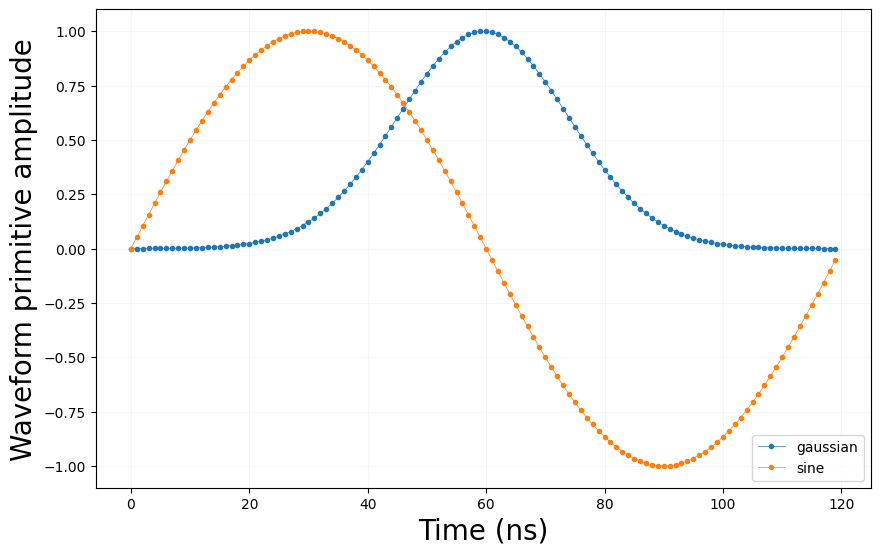

In [9]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude", fontsize=20)
ax.set_xlabel("Time (ns)", fontsize=20)

plt.draw()
plt.show()

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create 5 acquisition specifications that
each create a single bin. However, we will not be using the bins in this tutorial.

In [10]:
# Acquisitions
acquisitions = {
    "single": {"num_bins": 1, "index": 0},
    "multiple_0": {"num_bins": 1, "index": 1},
    "multiple_1": {"num_bins": 1, "index": 2},
    "multiple_2": {"num_bins": 1, "index": 3},
    "avg": {"num_bins": 1, "index": 4},
}

Create Q1ASM program
--------------------

Now that we have the waveforms and acquisitions specification for the sequence, we need a simple Q1ASM program that sequences and acquires the waveforms.
For a reference of available commands with Q1ASM please visit [Q1 Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html). Note how the Q1ASM references the JSON structures stored in the JSON file

In [11]:
# Sequence program.
seq_prog = """
play    0,1,4     #Play waveforms and wait 4ns. Parameters: waveform index (from dict) on path 0, waveform index (from dict) on path 1, wait (in ns)
acquire 0,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition. Parameters: acquisition index (from dict), data bin, Duration of acq (in ns)
stop              #Stop.
"""

Create and Upload sequence
--------------------------

Now that we have the waveform and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [12]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [13]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers to trigger the acquisition with the `acquire` instruction.

In [14]:
# Configure the sequencer to trigger the scope acquisition.
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Map sequencer to specific outputs (but first disable all sequencer connections)
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

readout_module.sequencer0.connect_sequencer("io0_1")

Now let's start the sequence.

In [15]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print("Status:")
print(readout_module.get_sequencer_status(0))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:2414: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:85: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:77: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
        

Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs. Lets make sure that the sequencer has finished it's acquisition and then retrieve the
resulting data. The acquisition data is stored in a temporary memory in the instrument's FPGA. We need to first move the data from this memory into the into the
instrument's acquisition list. From there we can retrieve it from the instrument.

In [16]:
# Wait for the acquisition to finish with a timeout period of one minute.
readout_module.get_acquisition_status(0, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "single")

# Get acquisition list from instrument.
single_acq = readout_module.get_acquisitions(0)

c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:3210: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(


Let's plot the result.

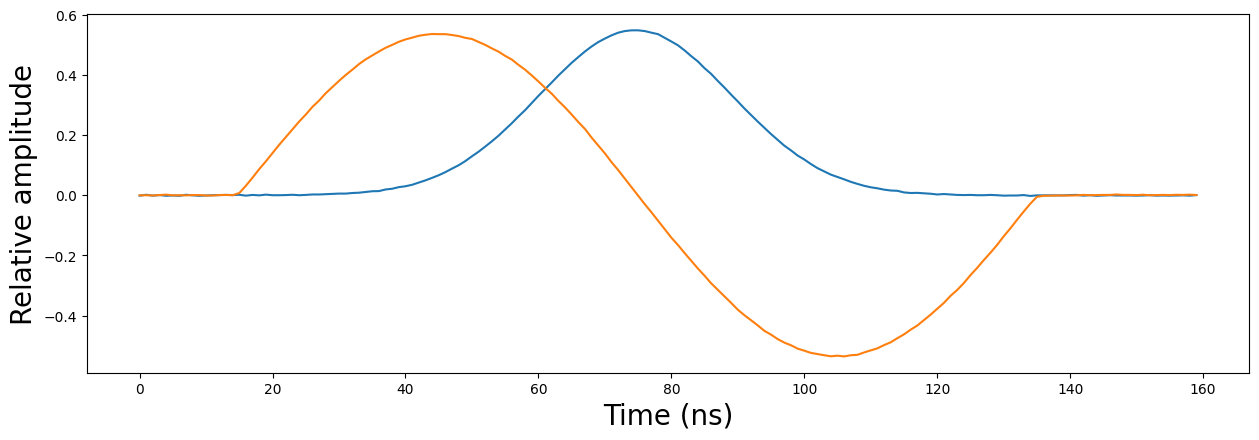

In [17]:
# Plot acquired signal on both inputs.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(single_acq["single"]["acquisition"]["scope"]["path0"]["data"][130:290])
ax.plot(single_acq["single"]["acquisition"]["scope"]["path1"]["data"][130:290])
ax.set_xlabel("Time (ns)", fontsize=20)
ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

Retrieve multiple acquisitions
------------------------------

We can also run the sequence multiple times consecutively and store the acquisition data in the instrument's acquisition list before retrieving them all in
one go. To demonstrate this we will run the same sequence three times and vary the output gain for each run to create a clear distinction between the acquisitions.

In [18]:
# First run
readout_module.sequencer0.gain_awg_path0(0.33)
readout_module.sequencer0.gain_awg_path1(0.33)

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

readout_module.get_acquisition_status(0, 1)

readout_module.store_scope_acquisition(0, "multiple_0")

# Second run
readout_module.sequencer0.gain_awg_path0(0.66)
readout_module.sequencer0.gain_awg_path1(0.66)

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

readout_module.get_acquisition_status(0, 1)

readout_module.store_scope_acquisition(0, "multiple_1")

# Third run
readout_module.sequencer0.gain_awg_path0(1)
readout_module.sequencer0.gain_awg_path1(1)

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

readout_module.get_acquisition_status(0, 1)

readout_module.store_scope_acquisition(0, "multiple_2")

# Get acquisition list from instrument.
multiple_acq = readout_module.get_acquisitions(0)

Let's plot the result again.

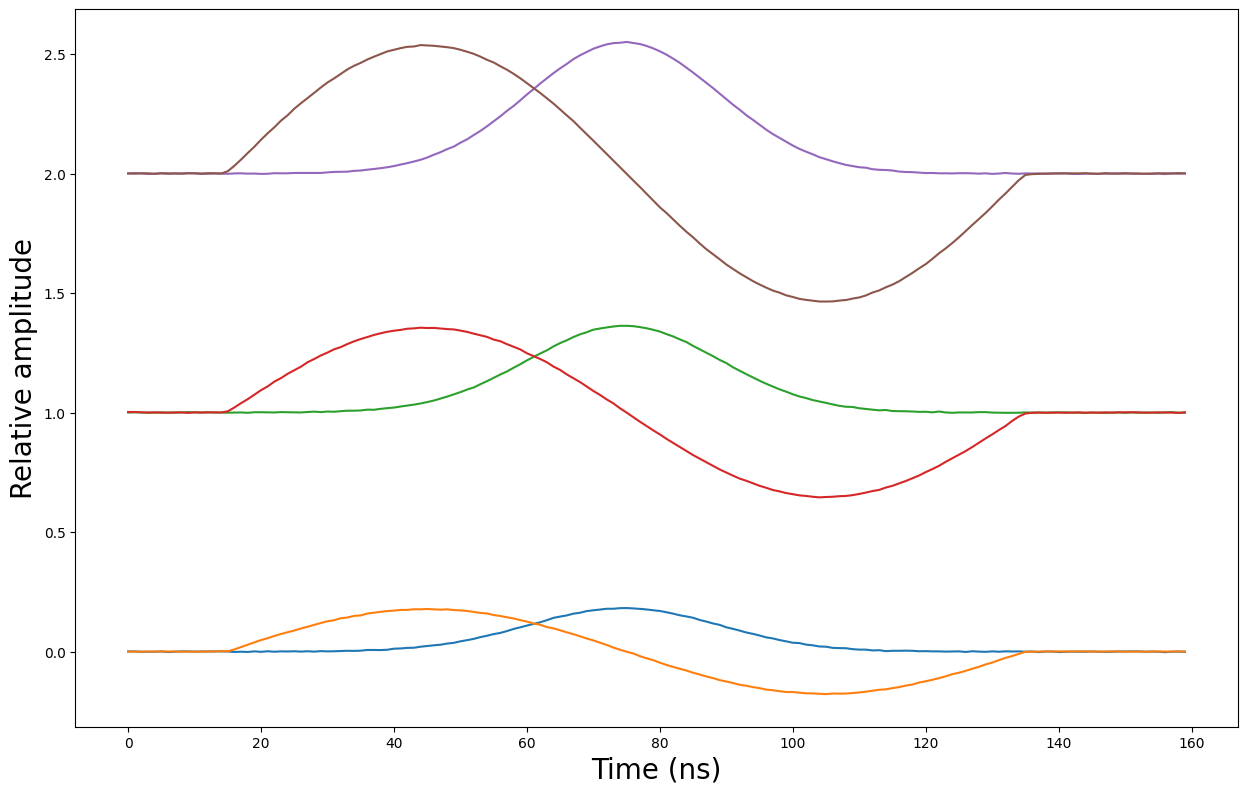

In [19]:
# Plot acquired signals (add acquisition index to separate acquisitions in plot).
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 1.61))
for acq_idx in range(0, 3):
    ax.plot(
        np.array(
            multiple_acq[f"multiple_{acq_idx}"]["acquisition"]["scope"]["path0"]["data"][130:290]
        )
        + acq_idx
    )
    ax.plot(
        np.array(
            multiple_acq[f"multiple_{acq_idx}"]["acquisition"]["scope"]["path1"]["data"][130:290]
        )
        + acq_idx
    )
    ax.set_xlabel("Time (ns)", fontsize=20)
    ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

### No Demodulation on Scope Acquisition

The scope acquisition is carried out before the incoming signal is demodulated. As a result, the acquired signal needs to be demodulated in software in order to retrieve the original waveform for a non-zero NCO frequency.

Hardware-based averaging
------------------------

We can also use hardware in the instrument itself to automatically accumulate acquisition data on-the-fly. This can be used to do averaging, by dividing the final
accumulated result by the number of accumulations. To use this feature, we first need to modify the Q1ASM program to run the sequence multiple consecutive times.

In [20]:
# Sequence program.
seq_prog = """
      move    1000,R0   #Loop iterator.

loop: play    0,1,4     #Play waveforms and wait 4ns.
      acquire 4,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition.
      loop    R0,@loop  #Run until number of iterations is done.

      stop              #Stop.
"""

Next, we need to program, configure and start the sequencer with the updated Q1ASM program. This time we will also configure the sequencer to run in averaging mode.

In [21]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("avg_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Upload sequence.
readout_module.sequencer0.sequence("avg_sequence.json")

# Enable hardware averaging
readout_module.scope_acq_avg_mode_en_path0(True)
readout_module.scope_acq_avg_mode_en_path1(True)

# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for sequence and acquisitions to finish.
readout_module.get_acquisition_status(0, 1)

# Move accumulated result from temporary memory to the instrument's acquisition list.
readout_module.store_scope_acquisition(0, "avg")

# Get acquisition list from instrument.
avg_acq = readout_module.get_acquisitions(0)

The sequence has now run and accumulated a 1000 times. Time to finish the averaging process and print the result.

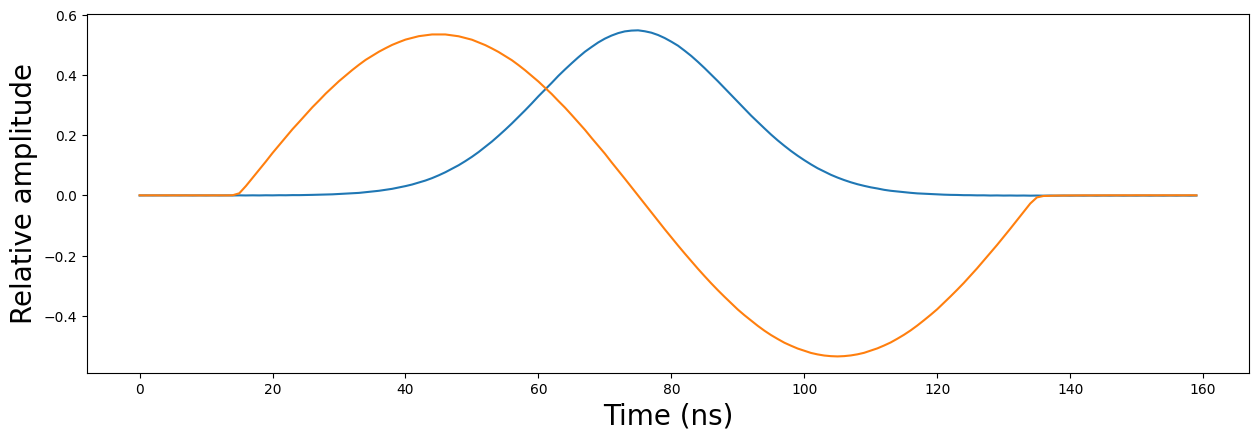

In [22]:
# Plot results.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(np.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][130:290]))
ax.plot(np.array(avg_acq["avg"]["acquisition"]["scope"]["path1"]["data"][130:290]))
ax.set_xlabel("Time (ns)", fontsize=20)
ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

Note that the accumulated acquisitions have already been averaged when the data is returned. The instrument keeps track of the number of accumulations and divides the result upon returning the data. The number of accumulations is also available for review.

In [23]:
# Print number of averages
print(avg_acq["avg"]["acquisition"]["scope"]["path0"]["avg_cnt"])
print(avg_acq["avg"]["acquisition"]["scope"]["path1"]["avg_cnt"])

1000
1000


To show that the hardware averaging worked, let's compare and zoom in on the data from the very first acquisition in this tutorial and the very last.

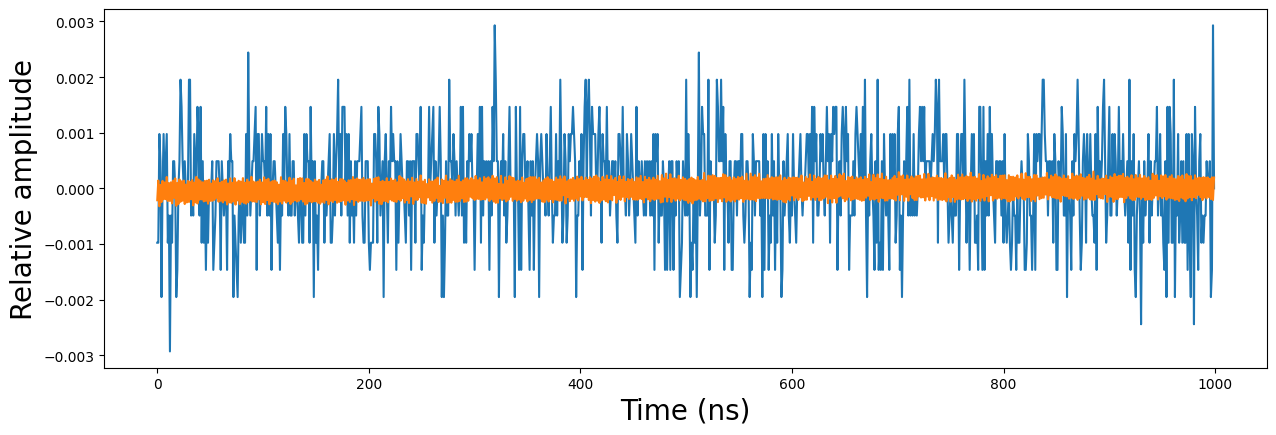

In [24]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(np.array(single_acq["single"]["acquisition"]["scope"]["path0"]["data"][1000:2000]))
ax.plot(np.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][1000:2000]))
ax.set_xlabel("Time (ns)", fontsize=20)
ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [25]:
# Stop sequencer.
readout_module.stop_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0))
print()

# Print an overview of the instrument parameters.
print("Snapshot:")
readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_status())

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE

Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	True 
scope_acq_avg_mode_en_path1   :	True 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

Status: OKAY, Flags: NONE, Slot flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:1033: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
